# 基于时间步的LSTM时序模型

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 数据预处理

读取数据

In [2]:
df = pd.read_csv('data/international-airline-passengers.csv')
# 将月份数据添加'-01'后转为时间类型
df['Month'] = df['Month'].map(lambda x: x + '-01')
df['Month'] = pd.to_datetime(df['Month'])
df.head(5)

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


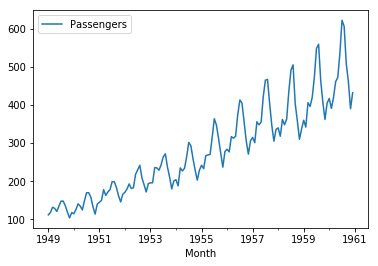

In [3]:
df.plot(x='Month', y='Passengers')

将数据集按照时间分为训练集和测试集，前75%的数据作为训练集，后25%的数据作为测试集

In [4]:
test_size = int(df.shape[0] * 0.25)

df_train = df.iloc[:-test_size].copy()
df_test = df.iloc[-test_size:].copy()

df_train.shape, df_test.shape

((108, 2), (36, 2))

对数据做标准化处理

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train['Passengers_scaled'] = scaler.fit_transform(df_train[['Passengers']])
df_test['Passengers_scaled'] = scaler.transform(df_test[['Passengers']])

生成训练集和测试集

In [6]:
# 时间窗口大小
LOOK_BACK = 12

def generate_data(data):
    X = np.empty((0, LOOK_BACK, 1))
    y = []
    for i in range(LOOK_BACK, data.shape[0]):
        x = np.array(data['Passengers_scaled'].iloc[(i - LOOK_BACK):i])
        x = x.reshape((-1, 1))
        X = np.vstack((X, x[np.newaxis, ...]))
        
        y.append(data.iat[i, 2])
        
    return X, np.array(y)

In [7]:
X_train, y_train = generate_data(df_train)
X_test, y_test = generate_data(df_test)

X_train.shape, X_test.shape

((96, 12, 1), (24, 12, 1))

## 建立模型

In [8]:
from keras.models import Sequential
from keras import layers

HIDDEN_SIZE = 16

Using TensorFlow backend.


定义网络结构

In [9]:
model = Sequential()

model.add(layers.LSTM(HIDDEN_SIZE, input_shape=(LOOK_BACK, 1)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

训练模型

In [10]:
model.fit(X_train, y_train, 
          batch_size=1, epochs=150, verbose=0)

查看在测试集上的rmse

In [11]:
from sklearn.metrics import mean_squared_error

y_pred_scaled = model.predict(X_test)
y_pred = y_pred_scaled * np.sqrt(scaler.var_) + scaler.mean_

np.sqrt(mean_squared_error(df_test['Passengers'][-y_pred.shape[0]:], y_pred))

48.85682006324745

画出源数据和预测数据图

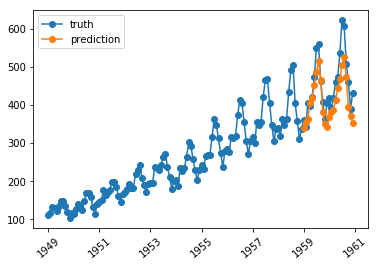

In [12]:
plt.plot(df['Month'], df['Passengers'], '-o', label='truth')
plt.plot(df_test['Month'][-y_pred.shape[0]:], y_pred.flatten(), '-o', label='prediction')
plt.xticks(rotation=40)
plt.legend()
plt.show()